In [1]:
import sys
import yaml
import torch
import logging
from pathlib import Path

# Add the path to the directory containing the omnicell package
# Assuming the omnicell package is in the parent directory of your notebook
sys.path.append('/orcd/data/omarabu/001/tanush20/omnicell/')  # Adjust this path as needed

import yaml
import torch
import logging
from pathlib import Path
from omnicell.config.config import Config, ETLConfig, ModelConfig, DatasplitConfig, EvalConfig, EmbeddingConfig
from omnicell.data.loader import DataLoader
from omnicell.constants import PERT_KEY, GENE_EMBEDDING_KEY, CONTROL_PERT
from omnicell.models.scot.scot import SCOT
from omnicell.models.scot.proportional import ProportionalSCOT
from omnicell.models.selector import load_model as get_model

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configure paths
MODEL_CONFIG = ModelConfig.from_yaml("/orcd/data/omarabu/001/tanush20/omnicell/configs/models/scot/scot.yaml")
ETL_CONFIG = ETLConfig(name = "no_preprocessing", log1p = False, drop_unmatched_perts = False)
EMBEDDING_CONFIG = EmbeddingConfig(pert_embedding='GenePT')

SPLIT_CONFIG = DatasplitConfig.from_yaml("/orcd/data/omarabu/001/njwfish/omnicell/configs/splits/repogle_k562_essential_raw/random_splits/rs_accP_k562_ood_ss:ns_20_2_most_pert_0.1/split_0/split_config.yaml")
EVAL_CONFIG = EvalConfig.from_yaml("/orcd/data/omarabu/001/njwfish/omnicell/configs/splits/repogle_k562_essential_raw/random_splits/rs_accP_k562_ood_ss:ns_20_2_most_pert_0.1/split_0/eval_config.yaml")  # Set this if you want to run evaluations

# Load configurations
config = Config(model_config=MODEL_CONFIG,
                 etl_config=ETL_CONFIG, 
                 datasplit_config=SPLIT_CONFIG, 
                 eval_config=EVAL_CONFIG)




#Alternatively you can initialize the config objects manually as follows:
# etl_config = ETLConfig(name = XXX, log1p = False, drop_unmatched_perts = False, ...)
# model_config = ...
# embedding_config = ...
# datasplit_config = ...
# eval_config = ...
# config = Config(etl_config, model_config, datasplit_config, eval_config)

# Set up device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize data loader and load training data
loader = DataLoader(config)
adata, pert_rep_map = loader.get_training_data()

# Get dimensions and perturbation IDs
input_dim = adata.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pert_ids = adata.obs[PERT_KEY].unique()
gene_emb_dim = adata.varm[GENE_EMBEDDING_KEY].shape[1] if GENE_EMBEDDING_KEY in adata.varm else None

print(f"Data loaded:")
print(f"- Number of cells: {adata.shape[0]}")
print(f"- Input dimension: {input_dim}")
print(f"- Number of perturbations: {len(pert_ids)}")


2025-02-16 22:29:36,145 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-16 22:29:36,147 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-16 22:29:36,149 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-16 22:29:36,151 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-16 22:29:36,152 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-16 22:29:36,154 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-16 22:29:36,156 - INFO - Loading data catalogue from /

Using device: cuda


2025-02-16 22:29:39,942 - INFO - Loaded unpreprocessed data, # of data points: 310385, # of genes: 8563.
2025-02-16 22:29:39,943 - INFO - Preprocessing training data
2025-02-16 22:29:39,945 - INFO - Using identity features for perturbations
2025-02-16 22:30:05,687 - INFO - Doing OOD split


Data loaded:
- Number of cells: 304701
- Input dimension: 8563
- Number of perturbations: 2038


In [3]:
model = get_model(config.model_config, loader, pert_rep_map, input_dim, device, pert_ids)

2025-02-16 22:30:05,940 - INFO - SCOT model selected


This is working


## 2. Model 2 (Pert-cell GNN & Gene GNN)
pert_embeddings are learnt through GNN by aggregating info across cells for each gene. This is passed to main GNN that aggregates info across control cells for each gene. Ran for 100 epochs. Random spike in loss near the end of training giving weird results.

In [ ]:
## 2: Pert GNN + 100 epochs   
class SCOT(torch.nn.Module):
    def __init__(self, adata, pert_embedding, cell_embed_dim, gene_embed_dim, hidden_dim, max_epochs=10):
        super(SCOT, self).__init__()
        print("This is working")
        self.total_adata = adata
 
        self.total_genes = adata.shape[1]
        self.pert_embedding = pert_embedding
       
        self.cell_embedder = CellEmbedding(self.total_genes, hidden_dim, cell_embed_dim)
        self.gnn = FCGNN(1 + cell_embed_dim + 2, hidden_dim, 1)
        self.max_epochs = max_epochs

        self.gnn_pert = FCGNN(gene_embed_dim + 2, hidden_dim, 1)
        self.pert_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)

    def forward(self, ctrl, shift_vec, pert, gene_indices=None):
        device = ctrl.device
        if gene_indices is None:
            gene_indices = torch.arange(self.total_genes).to(device)
        
        num_cells = torch.tensor(ctrl.shape[0]).to(device)
        num_cells_pert = torch.tensor(pert.shape[0]).to(device)
        num_genes = gene_indices.shape[0]
        
        cell_embed = self.cell_embedder(ctrl)
        cell_embed = torch.tile(cell_embed[:, None, :], (1, num_genes, 1))


        pert_embed_orig = self.pert_embedder(gene_indices)
        pert_gene_embed = torch.tile(pert_embed_orig, (num_cells_pert, 1, 1))

        ctrl = ctrl[:, gene_indices]
        shift_vec = shift_vec[gene_indices]
        pert = pert[:,gene_indices]

        shift_pert = torch.tile(shift_vec[None, :, None], (num_cells_pert, 1, 1))
        pert_embed = torch.cat((pert_gene_embed, pert[:, :, None], shift_pert), dim=2)
    
        h_pert = torch.vmap(self.gnn_pert, in_dims=0)(pert_embed)
        h_pert = torch.mean(h_pert, dim = 0)
        h_pert = h_pert.unsqueeze(0)
        h_pert = torch.tile(h_pert, (num_cells, 1, 1))
    

        num_cells = torch.tile(num_cells, (num_cells, num_genes, 1))

        ctrl_and_embed = torch.cat([ctrl[:, :, None], cell_embed, h_pert, num_cells], dim=2)
        h_gene = torch.vmap(self.gnn, in_dims=1)(ctrl_and_embed)
   
        output = torch.transpose(h_gene, 0, 1).squeeze()
        weighted_dist = torch.nn.Softmax(dim=0)(output)

        return weighted_dist


    def loss(self, ctrl, pert, n_projections=1000, negative_penalty=100):
        device = ctrl.device
        batch_size = torch.tensor(ctrl.shape[0]).to(device)
        shift_vec = pert.sum(axis=0) - ctrl.sum(axis=0)

        weighted_dist = self.forward(ctrl, shift_vec, pert)
        #pred_pert = (ctrl + (weighted_dist * (shift_vec + out)))
        pred_pert = (ctrl + (weighted_dist * (shift_vec)))
        loss = sliced_wasserstein_distance(pred_pert, pert, n_projections=n_projections) 
        loss -=negative_penalty * ((pred_pert < 0) * pred_pert).sum() / (batch_size * self.total_genes)
        #loss = loss + 0.0001 * torch.norm(out, p=2)
        return loss



In [4]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-16 09:17:34,971 - INFO - Training for 100 epochs
2025-02-16 09:18:42,629 - INFO - Epoch 1/100 - Loss: 1.9187844660026687
2025-02-16 09:19:48,221 - INFO - Epoch 2/100 - Loss: 1.1997501513075575
2025-02-16 09:20:57,053 - INFO - Epoch 3/100 - Loss: 1.164980893375145
2025-02-16 09:22:04,283 - INFO - Epoch 4/100 - Loss: 1.1208641116004372
2025-02-16 09:23:13,823 - INFO - Epoch 5/100 - Loss: 1.036161353496077
2025-02-16 09:24:21,154 - INFO - Epoch 6/100 - Loss: 1.0416583545913536
2025-02-16 09:25:30,606 - INFO - Epoch 7/100 - Loss: 1.0453159563707344
2025-02-16 09:26:38,534 - INFO - Epoch 8/100 - Loss: 1.0796480623453812
2025-02-16 09:27:47,485 - INFO - Epoch 9/100 - Loss: 1.117265191473318
2025-02-16 09:28:52,501 - INFO - Epoch 10/100 - Loss: 1.056794732388427
2025-02-16 09:30:00,347 - INFO - Epoch 11/100 - Loss: 1.0480952066546272
2025-02-16 09:31:08,227 - INFO - Epoch 12/100 - Loss: 1.0324472849416362
2025-02-16 09:32:17,247 - INFO - Epoch 13/100 - Loss: 1.0300501547404648
2025-02

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

2025-02-16 11:08:53,938 - INFO - Running evaluation
2025-02-16 11:08:53,941 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-16 11:08:53,943 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-16 11:08:53,944 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-16 11:08:53,946 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-16 11:08:53,948 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-16 11:08:53,949 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-16

In [6]:
import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packag

In [7]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.015381416199939213
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 404, 'Overlap_in_top_100_DEGs': 17, 'Overlap_in_top_50_DEGs': 8, 'Overlap_in_top_20_DEGs': 4, 'Jaccard': 0.18280542986425338}
----------------------------------------------------------------------------------------------------
0.5250856653945504
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 1733, 'Overlap_in_top_100_DEGs': 18, 'Overlap_in_top_50_DEGs': 8, 'Overlap_in_top_20_DEGs': 1, 'Jaccard': 0.4851623740201568}
----------------------------------------------------------------------------------------------------
0.21394364071205457
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 0, 'Overlap_in_top_100_DEGs': 0, 'Overlap_in_top_50_DEGs': 0, 'Overlap_in_top_20_DEGs': 0, 'Jaccard': 0.0}
----------------------------------------------------------------------------------------------------
0.15611310799071063
Cell: k562, Pert: RPL7
DEGs Overlaps: {'Overlap_in_top_

In [9]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")

Overlap_in_top_3483_DEGs: 0.0
Overlap_in_top_50_DEGs: 4.65
Overlap_in_top_100_DEGs: 10.15
Overlap_in_top_3845_DEGs: 93.0
Overlap_in_top_2669_DEGs: 47.0
Overlap_in_top_3789_DEGs: 0.0
Overlap_in_top_5259_DEGs: 0.0
Overlap_in_top_3714_DEGs: 0.0
Overlap_in_top_2671_DEGs: 0.0
Overlap_in_top_3107_DEGs: 1733.0
Overlap_in_top_2852_DEGs: 45.0
Jaccard: 0.07587467835192356
Overlap_in_top_20_DEGs: 1.2
Overlap_in_top_3430_DEGs: 19.0
Overlap_in_top_2157_DEGs: 404.0
Overlap_in_top_2389_DEGs: 1647.0
Overlap_in_top_3408_DEGs: 1.0
Overlap_in_top_2812_DEGs: 32.0
Overlap_in_top_4320_DEGs: 26.0
Overlap_in_top_4535_DEGs: 11.0
Overlap_in_top_4053_DEGs: 3.0
Overlap_in_top_3724_DEGs: 752.0
Overlap_in_top_3226_DEGs: 0.0
Overlap_in_top_3240_DEGs: 93.0


In [10]:
import pickle
with open('2_pert_embed_gnn_100_epochs_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

In [11]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")

Top_2812_DEGs_fold_diff_R2: 0.8316063604078933
Top_3483_DEGs_mean_R2: 0.9740712624481467
Top_2812_DEGs_cov_mtx_R2: 0.40187415779930924
Top_3408_DEGs_sub_diff_R2: 0.7348026498466672
Top_2389_DEGs_var_MSE: 0.004558245185762644
Top_3845_DEGs_corr_mtx_MSE: 0.00440324009222687
Top_2157_DEGs_mean_R2: 0.961833288724309
Top_100_DEGs_var_MSE: 0.021599633106961846
Top_50_DEGs_corr_mtx_R2: 0.7363171391299572
Top_3408_DEGs_corr_mtx_R: 0.5658456297310719
Top_3714_DEGs_corr_mtx_R2: 0.3114953004054419
Top_3408_DEGs_var_R2: 0.7773335705127993
Top_3724_DEGs_mean_R: 0.9798034522586253
Top_100_DEGs_fold_diff_R2: 0.6681946372314878
Top_100_DEGs_corr_mtx_R2: 0.6927524931836431
Top_3483_DEGs_cov_mtx_R: 0.4524277950106841
Top_2669_DEGs_corr_mtx_R2: 0.19674290673120326
Top_3483_DEGs_var_MSE: 0.0014202070888131857
Top_3408_DEGs_cov_mtx_R2: 0.3641743788198592
Top_4535_DEGs_corr_mtx_MSE: 0.006182349526217058
Top_3240_DEGs_mean_MSE: 0.022397436201572418
Top_3789_DEGs_var_R2: 0.8654666729506044
Top_2812_DEGs_sub_d

In [12]:
import pickle
with open('2_pert_embed_gnn_100_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

## Model 3 (Pert-cell GNN & Ctrl-cell GNN & Gene GNN)
Added GNN for ctrl embeddings as well, rest same as model 2 (Pert-cell GNN & Gene GNN)

In [ ]:
## Pert GNN + cell GNN 20 epochs

class SCOT(torch.nn.Module):
    def __init__(self, adata, pert_embedding, cell_embed_dim, gene_embed_dim, hidden_dim, max_epochs=10):
        super(SCOT, self).__init__()
        print("This is working")
        self.total_adata = adata
 
        self.total_genes = adata.shape[1]
        self.pert_embedding = pert_embedding
       
        self.cell_embedder = CellEmbedding(self.total_genes, hidden_dim, cell_embed_dim)
        self.gene_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)
        self.gnn = FCGNN(gene_embed_dim + 4, hidden_dim, 1)
        self.gnn_cell = FCGNN(gene_embed_dim + cell_embed_dim + 2, hidden_dim, 1)
        self.max_epochs = max_epochs

        self.gnn_pert = FCGNN(gene_embed_dim + 2, hidden_dim, 1)
        self.pert_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)

    def forward(self, ctrl, shift_vec, pert, gene_indices=None):
        device = ctrl.device
        if gene_indices is None:
            gene_indices = torch.arange(self.total_genes).to(device)
        
        num_cells = torch.tensor(ctrl.shape[0]).to(device)
        num_cells_pert = torch.tensor(pert.shape[0]).to(device)
        num_genes = gene_indices.shape[0]
        
        cell_embed = self.cell_embedder(ctrl)
        cell_embed = torch.tile(cell_embed[:, None, :], (1, num_genes, 1))

        gene_embed_orig = self.gene_embedder(gene_indices)
        gene_embed = torch.tile(gene_embed_orig, (num_cells, 1, 1))

        pert_embed_orig = self.pert_embedder(gene_indices)
        pert_gene_embed = torch.tile(pert_embed_orig, (num_cells_pert, 1, 1))

        ctrl = ctrl[:, gene_indices]
        shift_vec = shift_vec[gene_indices]
        pert = pert[:,gene_indices]

        shift_pert = torch.tile(shift_vec[None, :, None], (num_cells_pert, 1, 1))
        pert_embed = torch.cat((pert_gene_embed, pert[:, :, None], shift_pert), dim=2)
        
        h_pert = torch.vmap(self.gnn_pert, in_dims=0)(pert_embed)
        h_pert = torch.mean(h_pert, dim = 0)
        h_pert = h_pert.unsqueeze(0)
        h_pert = torch.tile(h_pert, (num_cells, 1, 1))


        num_cells = torch.tile(num_cells, (num_cells, num_genes, 1))

        h_cell = torch.cat([ctrl[:, :, None], gene_embed, h_pert, cell_embed], dim=2)
        h_cell = torch.vmap(self.gnn_cell, in_dims=0)(h_cell)

        ctrl_and_embed = torch.cat([ctrl[:, :, None], gene_embed, h_cell, h_pert, num_cells], dim=2)
        h_gene = torch.vmap(self.gnn, in_dims=1)(ctrl_and_embed)
   
        output = torch.transpose(h_gene, 0, 1).squeeze()
        weighted_dist = torch.nn.Softmax(dim=0)(output)

        return weighted_dist


    def loss(self, ctrl, pert, n_projections=1000, negative_penalty=100):
        device = ctrl.device
        batch_size = torch.tensor(ctrl.shape[0]).to(device)
        shift_vec = pert.sum(axis=0) - ctrl.sum(axis=0)

        weighted_dist = self.forward(ctrl, shift_vec, pert)
     
        pred_pert = (ctrl + (weighted_dist * (shift_vec)))
        loss = sliced_wasserstein_distance(pred_pert, pert, n_projections=n_projections) 
        loss -=negative_penalty * ((pred_pert < 0) * pred_pert).sum() / (batch_size * self.total_genes)

        return loss


In [4]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-16 11:45:14,900 - INFO - Training for 20 epochs
2025-02-16 11:46:40,882 - INFO - Epoch 1/20 - Loss: 1.9521384038517822
2025-02-16 11:48:06,355 - INFO - Epoch 2/20 - Loss: 1.0648451439414972
2025-02-16 11:49:31,439 - INFO - Epoch 3/20 - Loss: 1.0770824330109765
2025-02-16 11:50:56,499 - INFO - Epoch 4/20 - Loss: 1.0577532019574563
2025-02-16 11:52:21,592 - INFO - Epoch 5/20 - Loss: 1.053233779839107
2025-02-16 11:53:46,240 - INFO - Epoch 6/20 - Loss: 1.055253737623804
2025-02-16 11:55:10,981 - INFO - Epoch 7/20 - Loss: 1.089602407732646
2025-02-16 11:56:36,211 - INFO - Epoch 8/20 - Loss: 1.0171478137581036
2025-02-16 11:58:01,213 - INFO - Epoch 9/20 - Loss: 1.0340092022845513
2025-02-16 11:59:26,477 - INFO - Epoch 10/20 - Loss: 1.0592122675933382
2025-02-16 12:00:51,857 - INFO - Epoch 11/20 - Loss: 1.0213809264950278
2025-02-16 12:02:17,013 - INFO - Epoch 12/20 - Loss: 1.0721100404636499
2025-02-16 12:03:41,480 - INFO - Epoch 13/20 - Loss: 1.0324178917091094
2025-02-16 12:05:06,

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-16 12:13:35,379 - INFO - Running evaluation
2025-02-16 12:13:35,381 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-16 12:13:35,383 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-16 12:13:35,384 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-16 12:13:35,386 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-16 12:13:35,388 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-16 12:13:35,389 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-16

In [6]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.4169912940666338
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1529, 'Overlap_in_top_100_DEGs': 76, 'Overlap_in_top_50_DEGs': 33, 'Overlap_in_top_20_DEGs': 10, 'Jaccard': 0.31799227799227797}
----------------------------------------------------------------------------------------------------
0.7371213453788518
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2327, 'Overlap_in_top_100_DEGs': 78, 'Overlap_in_top_50_DEGs': 37, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.43471267729200175}
----------------------------------------------------------------------------------------------------
0.42284805759816513
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2558, 'Overlap_in_top_100_DEGs': 67, 'Overlap_in_top_50_DEGs': 37, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.5406526050117181}
----------------------------------------------------------------------------------------------------
0.36971362155563825
Cell: k562, Pert: RPL7
DEGs Ov

In [7]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('3_pert_embed_gnn_cell_gnn_20_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_3724_DEGs_sub_diff_R2: 0.9669371242949266
Top_2389_DEGs_var_MSE: 0.0034963947255164385
Top_4053_DEGs_corr_mtx_R: 0.3829707668890252
Top_2671_DEGs_fold_diff_MSE: 0.05486442521214485
Top_3240_DEGs_fold_diff_R2: 0.966144885077555
Top_3107_DEGs_mean_MSE: 0.0014569564955309033
Top_2669_DEGs_corr_mtx_R: 0.2917793807096836
Top_2669_DEGs_fold_diff_MSE: 0.09287677705287933
Top_3408_DEGs_fold_diff_MSE: 0.20051132142543793
all_genes_corr_mtx_R: 0.2168526765138926
Top_3226_DEGs_cov_mtx_R2: 0.1587187045286876
Top_50_DEGs_mean_R: 0.9968422133320166
Top_20_DEGs_var_R2: 0.518000934859286
Top_2812_DEGs_fold_diff_R: 0.9960808762473234
Top_100_DEGs_corr_mtx_R: 0.6193962797477541
Top_3845_DEGs_fold_diff_R2: 0.9971997964431794
Top_100_DEGs_cov_mtx_MSE: 0.006714122801037175
Top_3408_DEGs_mean_R: 0.9992623566987702
Top_3789_DEGs_mean_MSE: 0.000987346633337438
Top_3430_DEGs_cov_mtx_R2: 0.13589544286923433
Top_2812_DEGs_var_R: 0.8354676383221041
Top_3845_DEGs_fold_diff_R: 0.998598916704389
Top_3724_DEGs_co

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('3_pert_embed_gnn_cell_gnn_20_epochs_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_5259_DEGs: 4175.0
Overlap_in_top_2852_DEGs: 2322.0
Overlap_in_top_2812_DEGs: 1745.0
Overlap_in_top_4320_DEGs: 3182.0
Overlap_in_top_3724_DEGs: 2527.0
Overlap_in_top_4053_DEGs: 3341.0
Overlap_in_top_3240_DEGs: 2653.0
Overlap_in_top_50_DEGs: 38.2
Overlap_in_top_3483_DEGs: 2526.0
Overlap_in_top_2389_DEGs: 1564.0
Overlap_in_top_20_DEGs: 14.0
Overlap_in_top_3789_DEGs: 2684.0
Overlap_in_top_100_DEGs: 75.35
Overlap_in_top_4535_DEGs: 4005.0
Overlap_in_top_3845_DEGs: 2641.0
Overlap_in_top_3430_DEGs: 2453.0
Overlap_in_top_3226_DEGs: 2758.0
Overlap_in_top_3107_DEGs: 2327.0
Overlap_in_top_2157_DEGs: 1529.0
Jaccard: 0.4936693816411446
Overlap_in_top_2671_DEGs: 1780.0
Overlap_in_top_3714_DEGs: 2558.0
Overlap_in_top_2669_DEGs: 2086.0
Overlap_in_top_3408_DEGs: 2212.0


## Model 2 (Pert-cell GNN & Gene GNN)
Same as model 2 (pert GNN), ran for 20 epochs

In [ ]:
## Pert GNN 20 epochs

class SCOT(torch.nn.Module):
    def __init__(self, adata, pert_embedding, cell_embed_dim, gene_embed_dim, hidden_dim, max_epochs=10):
        super(SCOT, self).__init__()
        print("This is working")
        self.total_adata = adata
 
        self.total_genes = adata.shape[1]
        self.pert_embedding = pert_embedding
       
        self.cell_embedder = CellEmbedding(self.total_genes, hidden_dim, cell_embed_dim)
        self.gene_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)
        self.gnn = FCGNN(cell_embed_dim + gene_embed_dim + 3, hidden_dim, 1)
        #self.gnn_cell = FCGNN(gene_embed_dim + cell_embed_dim + 2, hidden_dim, 1)
        self.max_epochs = max_epochs

        #self.pert_embedder = CellEmbedding(3, hidden_dim, 1)
        self.gnn_pert = FCGNN(gene_embed_dim + 2, hidden_dim, 1)
        self.pert_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)

    def forward(self, ctrl, shift_vec, pert, gene_indices=None):
        device = ctrl.device
        if gene_indices is None:
            gene_indices = torch.arange(self.total_genes).to(device)
        
        num_cells = torch.tensor(ctrl.shape[0]).to(device)
        num_cells_pert = torch.tensor(pert.shape[0]).to(device)
        num_genes = gene_indices.shape[0]
        
        cell_embed = self.cell_embedder(ctrl)
        cell_embed = torch.tile(cell_embed[:, None, :], (1, num_genes, 1))

        gene_embed_orig = self.gene_embedder(gene_indices)
        gene_embed = torch.tile(gene_embed_orig, (num_cells, 1, 1))

        pert_embed_orig = self.pert_embedder(gene_indices)
        pert_gene_embed = torch.tile(pert_embed_orig, (num_cells_pert, 1, 1))

        ctrl = ctrl[:, gene_indices]
        shift_vec = shift_vec[gene_indices]
        pert = pert[:,gene_indices]
        shift_pert = torch.tile(shift_vec[None, :, None], (num_cells_pert, 1, 1))
        pert_embed = torch.cat((pert_gene_embed, pert[:, :, None], shift_pert), dim=2)
 
        h_pert = torch.vmap(self.gnn_pert, in_dims=0)(pert_embed)
        h_pert = torch.mean(h_pert, dim = 0)
        h_pert = h_pert.unsqueeze(0)
        h_pert = torch.tile(h_pert, (num_cells, 1, 1))
     
        num_cells = torch.tile(num_cells, (num_cells, num_genes, 1))


        ctrl_and_embed = torch.cat([ctrl[:, :, None], gene_embed, cell_embed, h_pert, num_cells], dim=2)
        h_gene = torch.vmap(self.gnn, in_dims=1)(ctrl_and_embed)
   
        output = torch.transpose(h_gene, 0, 1).squeeze()
        weighted_dist = torch.nn.Softmax(dim=0)(output)

        return weighted_dist


    def loss(self, ctrl, pert, n_projections=1000, negative_penalty=100):
        device = ctrl.device
        batch_size = torch.tensor(ctrl.shape[0]).to(device)
        shift_vec = pert.sum(axis=0) - ctrl.sum(axis=0)

        weighted_dist = self.forward(ctrl, shift_vec, pert)
       
        pred_pert = (ctrl + (weighted_dist * (shift_vec)))
        loss = sliced_wasserstein_distance(pred_pert, pert, n_projections=n_projections) 
        loss -=negative_penalty * ((pred_pert < 0) * pred_pert).sum() / (batch_size * self.total_genes)
    
        return loss



In [7]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-16 12:50:49,525 - INFO - Training for 20 epochs
2025-02-16 12:51:59,799 - INFO - Epoch 1/20 - Loss: 1.95571395523423
2025-02-16 12:53:09,231 - INFO - Epoch 2/20 - Loss: 1.0598317714367462
2025-02-16 12:54:18,906 - INFO - Epoch 3/20 - Loss: 1.0988563315033655
2025-02-16 12:55:27,844 - INFO - Epoch 4/20 - Loss: 1.0949477908262135
2025-02-16 12:56:36,676 - INFO - Epoch 5/20 - Loss: 1.0726027749237785
2025-02-16 12:57:45,041 - INFO - Epoch 6/20 - Loss: 1.0349934584603333
2025-02-16 12:58:54,202 - INFO - Epoch 7/20 - Loss: 1.0524077453614968
2025-02-16 13:00:03,139 - INFO - Epoch 8/20 - Loss: 1.0901331892230448
2025-02-16 13:01:12,278 - INFO - Epoch 9/20 - Loss: 1.0295558411951493
2025-02-16 13:02:20,807 - INFO - Epoch 10/20 - Loss: 1.04347258797798
2025-02-16 13:03:29,662 - INFO - Epoch 11/20 - Loss: 1.0261233392775184
2025-02-16 13:04:38,895 - INFO - Epoch 12/20 - Loss: 1.006421120191107
2025-02-16 13:05:47,748 - INFO - Epoch 13/20 - Loss: 1.020190096798578
2025-02-16 13:06:56,670

In [8]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-16 13:13:49,521 - INFO - Running evaluation
2025-02-16 13:13:49,522 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-16 13:13:49,525 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-16 13:13:49,526 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-16 13:13:49,528 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-16 13:13:49,529 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-16 13:13:49,531 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-16

In [9]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.4111430148252265
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1544, 'Overlap_in_top_100_DEGs': 76, 'Overlap_in_top_50_DEGs': 33, 'Overlap_in_top_20_DEGs': 10, 'Jaccard': 0.31820287169986106}
----------------------------------------------------------------------------------------------------
0.706173017176651
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2341, 'Overlap_in_top_100_DEGs': 77, 'Overlap_in_top_50_DEGs': 39, 'Overlap_in_top_20_DEGs': 15, 'Jaccard': 0.43552168815943726}
----------------------------------------------------------------------------------------------------
0.2925997808931174
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2592, 'Overlap_in_top_100_DEGs': 65, 'Overlap_in_top_50_DEGs': 34, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.5424613170205109}
----------------------------------------------------------------------------------------------------
0.23631432327683538
Cell: k562, Pert: RPL7
DEGs Over

In [10]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('2_pert_embed_gnn_20_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_4535_DEGs_sub_diff_MSE: 0.0033066244795918465
Top_2157_DEGs_fold_diff_MSE: 1.0484912395477295
Top_3789_DEGs_mean_MSE: 0.0012236476177349687
Top_3714_DEGs_sub_diff_R: 0.9866350259020171
Top_50_DEGs_var_R: 0.656642033745612
Top_4053_DEGs_sub_diff_R: 0.9885191646720602
Top_3408_DEGs_corr_mtx_MSE: 0.005439643426120704
Top_2389_DEGs_corr_mtx_R: 0.29978072040866366
Top_4053_DEGs_fold_diff_R2: 0.983541058485658
all_genes_mean_sub_diff_MSE: 0.0008021171423024497
Top_2812_DEGs_cov_mtx_R2: 0.13306118786724347
Top_4053_DEGs_mean_R: 0.9991491610376693
Top_50_DEGs_cov_mtx_R2: 0.3424777114138132
all_genes_var_R: 0.9371219965102758
Top_3430_DEGs_sub_diff_R2: 0.9731849191451245
Top_50_DEGs_fold_diff_R2: 0.9887588388453482
Top_20_DEGs_mean_R2: 0.9885120598058501
Top_3724_DEGs_corr_mtx_R: 0.2970216612041904
Top_3408_DEGs_corr_mtx_R2: 0.12097335333563426
Top_4320_DEGs_fold_diff_R2: 0.9942836899903552
Top_2157_DEGs_fold_diff_R2: 0.9779124584000997
Top_2157_DEGs_mean_R2: 0.9951796992136483
Top_3107_DEG

In [11]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('2_pert_embed_gnn_20_epochs_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_3483_DEGs: 2559.0
Overlap_in_top_3240_DEGs: 2661.0
Overlap_in_top_3845_DEGs: 2664.0
Overlap_in_top_3714_DEGs: 2592.0
Overlap_in_top_2671_DEGs: 1794.0
Overlap_in_top_3107_DEGs: 2341.0
Overlap_in_top_20_DEGs: 13.7
Overlap_in_top_4535_DEGs: 3985.0
Jaccard: 0.4950594736885995
Overlap_in_top_5259_DEGs: 4194.0
Overlap_in_top_2157_DEGs: 1544.0
Overlap_in_top_2812_DEGs: 1778.0
Overlap_in_top_50_DEGs: 37.65
Overlap_in_top_2852_DEGs: 2318.0
Overlap_in_top_3724_DEGs: 2538.0
Overlap_in_top_4053_DEGs: 3350.0
Overlap_in_top_3789_DEGs: 2718.0
Overlap_in_top_100_DEGs: 73.95
Overlap_in_top_2389_DEGs: 1577.0
Overlap_in_top_2669_DEGs: 2099.0
Overlap_in_top_3226_DEGs: 2722.0
Overlap_in_top_3408_DEGs: 2239.0
Overlap_in_top_4320_DEGs: 3190.0
Overlap_in_top_3430_DEGs: 2476.0


## Model 4 (Pert embedder through NN + Ctrl-cell GNN + Gene GNN)
Pert embeddings are learnt through normal NN, as a function of mean expression of gene, zero inflation of gene, shift vec and gene embedding. Cell GNN is also there that aggregates info across genes for each cell, and then this is passed to the gene GNN

In [ ]:
## Pert embeddings + cell gnn 20 epochs
class SCOT(torch.nn.Module):
    def __init__(self, adata, pert_embedding, cell_embed_dim, gene_embed_dim, hidden_dim, max_epochs=10):
        super(SCOT, self).__init__()
        print("This is working")
        self.total_adata = adata
 
        self.total_genes = adata.shape[1]
        self.pert_embedding = pert_embedding
       
        self.cell_embedder = CellEmbedding(self.total_genes, hidden_dim, cell_embed_dim)
        self.gene_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)
        self.gnn = FCGNN(gene_embed_dim + 4, hidden_dim, 1)
        self.gnn_cell = FCGNN(gene_embed_dim + cell_embed_dim + 2, hidden_dim, 1)
        self.max_epochs = max_epochs

        self.pert_embedder = CellEmbedding(gene_embed_dim + 3, hidden_dim, 1)
        self.gnn_pert = FCGNN(gene_embed_dim + 2, hidden_dim, 1)
       

    def forward(self, ctrl, shift_vec, pert, gene_indices=None):
        device = ctrl.device
        if gene_indices is None:
            gene_indices = torch.arange(self.total_genes).to(device)
        
        num_cells = torch.tensor(ctrl.shape[0]).to(device)
        num_cells_pert = torch.tensor(pert.shape[0]).to(device)
        num_genes = gene_indices.shape[0]
        
        cell_embed = self.cell_embedder(ctrl)
        cell_embed = torch.tile(cell_embed[:, None, :], (1, num_genes, 1))

        gene_embed_orig = self.gene_embedder(gene_indices)
        gene_embed = torch.tile(gene_embed_orig, (num_cells, 1, 1))

        ctrl = ctrl[:, gene_indices]
        shift_vec = shift_vec[gene_indices]
        pert = pert[:,gene_indices]

        pert_mean = torch.mean(pert, dim=0)
        pert_mean = pert_mean.unsqueeze(1)

        zero_counts = (pert == 0).sum(dim=0)  
        zero_counts = zero_counts.float() / pert.shape[0]
        zero_counts = zero_counts.unsqueeze(1)
        shift_orig = shift_vec.unsqueeze(1)
        shift = torch.tile(shift_vec[None, :, None], (num_cells, 1, 1))
  
        pert_embed = torch.cat((gene_embed_orig, pert_mean, zero_counts, shift_orig), dim=1)

        pert_embed_orig = self.pert_embedder(pert_embed)
        pert_embed = pert_embed_orig.unsqueeze(0) 
        pert_embed = torch.tile(pert_embed, (num_cells, 1, 1)) 
     

        num_cells = torch.tile(num_cells, (num_cells, num_genes, 1))

        h_cell = torch.cat([ctrl[:, :, None], gene_embed, pert_embed, cell_embed], dim=2)
        h_cell = torch.vmap(self.gnn_cell, in_dims=0)(h_cell)

        ctrl_and_embed = torch.cat([ctrl[:, :, None], gene_embed, h_cell, pert_embed, num_cells], dim=2)
        h_gene = torch.vmap(self.gnn, in_dims=1)(ctrl_and_embed)
   
        output = torch.transpose(h_gene, 0, 1).squeeze()
        weighted_dist = torch.nn.Softmax(dim=0)(output)

        return weighted_dist

    def loss(self, ctrl, pert, n_projections=1000, negative_penalty=100):
        device = ctrl.device
        batch_size = torch.tensor(ctrl.shape[0]).to(device)
        shift_vec = pert.sum(axis=0) - ctrl.sum(axis=0)

        weighted_dist = self.forward(ctrl, shift_vec, pert)
        #pred_pert = (ctrl + (weighted_dist * (shift_vec + out)))
        pred_pert = (ctrl + (weighted_dist * (shift_vec)))
        loss = sliced_wasserstein_distance(pred_pert, pert, n_projections=n_projections) 
        loss -=negative_penalty * ((pred_pert < 0) * pred_pert).sum() / (batch_size * self.total_genes)

        return loss



In [4]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-16 15:23:09,725 - INFO - Training for 20 epochs
2025-02-16 15:24:19,119 - INFO - Epoch 1/20 - Loss: 1.5676279451817534
2025-02-16 15:25:27,824 - INFO - Epoch 2/20 - Loss: 1.1384463099721345
2025-02-16 15:26:37,132 - INFO - Epoch 3/20 - Loss: 1.0418914087132447
2025-02-16 15:27:47,392 - INFO - Epoch 4/20 - Loss: 1.0164040568848116
2025-02-16 15:28:57,656 - INFO - Epoch 5/20 - Loss: 0.9953560153870518
2025-02-16 15:30:08,068 - INFO - Epoch 6/20 - Loss: 1.06995057366714
2025-02-16 15:31:16,719 - INFO - Epoch 7/20 - Loss: 1.0868074889171406
2025-02-16 15:32:25,572 - INFO - Epoch 8/20 - Loss: 1.0624805476015422
2025-02-16 15:33:35,385 - INFO - Epoch 9/20 - Loss: 1.0206022143194622
2025-02-16 15:34:42,967 - INFO - Epoch 10/20 - Loss: 1.015004516995732
2025-02-16 15:35:51,576 - INFO - Epoch 11/20 - Loss: 1.011756621550766
2025-02-16 15:37:01,252 - INFO - Epoch 12/20 - Loss: 0.9957683692681593
2025-02-16 15:38:11,773 - INFO - Epoch 13/20 - Loss: 1.1238966603543832
2025-02-16 15:39:21,6

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-16 15:46:15,647 - INFO - Running evaluation
2025-02-16 15:46:15,649 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-16 15:46:15,651 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-16 15:46:15,653 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-16 15:46:15,654 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-16 15:46:15,656 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-16 15:46:15,658 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-16

/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packag

In [6]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.5367658530987874
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1538, 'Overlap_in_top_100_DEGs': 76, 'Overlap_in_top_50_DEGs': 33, 'Overlap_in_top_20_DEGs': 10, 'Jaccard': 0.3168103448275862}
----------------------------------------------------------------------------------------------------
0.8035135685442486
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2359, 'Overlap_in_top_100_DEGs': 77, 'Overlap_in_top_50_DEGs': 38, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.4336891358385729}
----------------------------------------------------------------------------------------------------
0.45578187977081336
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2532, 'Overlap_in_top_100_DEGs': 69, 'Overlap_in_top_50_DEGs': 36, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.5279160739687055}
----------------------------------------------------------------------------------------------------
0.45280212836269584
Cell: k562, Pert: RPL7
DEGs Over

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('4_pert_embed_cell_gnn_20_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_5259_DEGs_mean_R: 0.9992592841501702
Top_3430_DEGs_fold_diff_MSE: 0.05482988804578781
Top_2157_DEGs_fold_diff_R2: 0.9624534882135016
Top_2852_DEGs_corr_mtx_R: 0.3312210480626974
Top_3408_DEGs_corr_mtx_MSE: 0.005570759191737005
Top_4535_DEGs_var_R2: 0.9025444619800922
Top_3789_DEGs_fold_diff_MSE: 0.1311694085597992
Top_3845_DEGs_var_MSE: 0.002580834086984396
Top_50_DEGs_mean_R: 0.9978386416403758
Top_2157_DEGs_fold_diff_MSE: 0.6315183043479919
Top_4053_DEGs_cov_mtx_R2: 0.24591853837977498
Top_2669_DEGs_cov_mtx_R2: 0.1270243896235422
Top_3483_DEGs_corr_mtx_R2: 0.1696068185791621
all_genes_corr_mtx_MSE: 0.005220023310792739
Top_2669_DEGs_var_MSE: 0.0023796793539077044
Top_4320_DEGs_mean_R2: 0.9986261800457216
Top_2671_DEGs_corr_mtx_R2: 0.14452655884837476
Top_50_DEGs_corr_mtx_R2: 0.4626217821658155
Top_3845_DEGs_corr_mtx_MSE: 0.005190725965096801
Top_2671_DEGs_sub_diff_R2: 0.9740263745651829
Top_2389_DEGs_corr_mtx_R: 0.2818588903320036
Top_4535_DEGs_sub_diff_MSE: 0.0018886830657720566

In [9]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('4_pert_embed_cell_gnn_20_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_4320_DEGs: 3140.0
Overlap_in_top_2669_DEGs: 2145.0
Overlap_in_top_2852_DEGs: 2372.0
Overlap_in_top_3107_DEGs: 2359.0
Overlap_in_top_2389_DEGs: 1559.0
Overlap_in_top_3724_DEGs: 2493.0
Overlap_in_top_4535_DEGs: 4025.0
Overlap_in_top_4053_DEGs: 3365.0
Overlap_in_top_2671_DEGs: 1750.0
Overlap_in_top_5259_DEGs: 4157.0
Overlap_in_top_20_DEGs: 13.9
Overlap_in_top_3845_DEGs: 2609.0
Overlap_in_top_3483_DEGs: 2512.0
Overlap_in_top_3789_DEGs: 2670.0
Jaccard: 0.48853916247662366
Overlap_in_top_3408_DEGs: 2197.0
Overlap_in_top_3430_DEGs: 2432.0
Overlap_in_top_2812_DEGs: 1740.0
Overlap_in_top_3714_DEGs: 2532.0
Overlap_in_top_50_DEGs: 38.65
Overlap_in_top_2157_DEGs: 1538.0
Overlap_in_top_3226_DEGs: 2804.0
Overlap_in_top_3240_DEGs: 2684.0
Overlap_in_top_100_DEGs: 76.9


## Model 5
Same as model 4 but with sinkhorn loss

In [ ]:
## Same as 4 but with sinkhorn loss

def sinkhorn_loss(X1, X2, epsilon=0.1, n_iters=100):
    """
    Computes the Sinkhorn loss (approximation of the Wasserstein distance) between two batches.

    Args:
        X1: Tensor of shape (N, d) - First batch of points.
        X2: Tensor of shape (M, d) - Second batch of points.
        epsilon: Entropy regularization coefficient (default: 0.1).
        n_iters: Number of iterations for the Sinkhorn algorithm (default: 100).

    Returns:
        Sinkhorn loss (scalar tensor).
    """
    N, _ = X1.shape
    M, _ = X2.shape
    device = X1.device
    
    # Compute the cost matrix
    C = torch.cdist(X1, X2, p=2) ** 2  # Squared Euclidean distance

    # Initialize dual variables
    u = torch.zeros(N, device=device)
    v = torch.zeros(M, device=device)

    # Sinkhorn iterations
    for _ in range(n_iters):
        u = epsilon * (torch.logsumexp(-C / epsilon + v[None, :], dim=1) - torch.log(torch.tensor(1.0 / N, device=device)))
        v = epsilon * (torch.logsumexp(-C / epsilon + u[:, None], dim=0) - torch.log(torch.tensor(1.0 / M, device=device)))

    # Compute the optimal transport plan
    P = torch.exp((-C + u[:, None] + v[None, :]) / epsilon)

    # Compute the Sinkhorn loss
    sinkhorn_loss_value = torch.sum(P * C)

    return sinkhorn_loss_value

class SCOT(torch.nn.Module):
    def __init__(self, adata, pert_embedding, cell_embed_dim, gene_embed_dim, hidden_dim, max_epochs=10):
        super(SCOT, self).__init__()
        print("This is working")
        self.total_adata = adata
 
        self.total_genes = adata.shape[1]
        self.pert_embedding = pert_embedding
       
        self.cell_embedder = CellEmbedding(self.total_genes, hidden_dim, cell_embed_dim)
        self.gene_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)
        self.gnn = FCGNN(gene_embed_dim + 4, hidden_dim, 1)
        self.gnn_cell = FCGNN(gene_embed_dim + cell_embed_dim + 2, hidden_dim, 1)
        self.max_epochs = max_epochs

        self.pert_embedder = CellEmbedding(gene_embed_dim + 3, hidden_dim, 1)
        self.gnn_pert = FCGNN(gene_embed_dim + 2, hidden_dim, 1)
      

    def forward(self, ctrl, shift_vec, pert, gene_indices=None):
        device = ctrl.device
        if gene_indices is None:
            gene_indices = torch.arange(self.total_genes).to(device)
        
        num_cells = torch.tensor(ctrl.shape[0]).to(device)
        num_cells_pert = torch.tensor(pert.shape[0]).to(device)
        num_genes = gene_indices.shape[0]
        
        cell_embed = self.cell_embedder(ctrl)
        cell_embed = torch.tile(cell_embed[:, None, :], (1, num_genes, 1))

        gene_embed_orig = self.gene_embedder(gene_indices)
        gene_embed = torch.tile(gene_embed_orig, (num_cells, 1, 1))


        ctrl = ctrl[:, gene_indices]
        shift_vec = shift_vec[gene_indices]
        pert = pert[:,gene_indices]

        pert_mean = torch.mean(pert, dim=0)
        pert_mean = pert_mean.unsqueeze(1)

        zero_counts = (pert == 0).sum(dim=0)  
        zero_counts = zero_counts.float() / pert.shape[0]
        zero_counts = zero_counts.unsqueeze(1)
        shift_orig = shift_vec.unsqueeze(1)
        shift = torch.tile(shift_vec[None, :, None], (num_cells, 1, 1))
      
        pert_embed = torch.cat((gene_embed_orig, pert_mean, zero_counts, shift_orig), dim=1)
 
        pert_embed_orig = self.pert_embedder(pert_embed)
        pert_embed = pert_embed_orig.unsqueeze(0) 
        pert_embed = torch.tile(pert_embed, (num_cells, 1, 1)) 
   
        num_cells = torch.tile(num_cells, (num_cells, num_genes, 1))

        h_cell = torch.cat([ctrl[:, :, None], gene_embed, pert_embed, cell_embed], dim=2)
        h_cell = torch.vmap(self.gnn_cell, in_dims=0)(h_cell)

        ctrl_and_embed = torch.cat([ctrl[:, :, None], gene_embed, h_cell, pert_embed, num_cells], dim=2)
        h_gene = torch.vmap(self.gnn, in_dims=1)(ctrl_and_embed)
   
        output = torch.transpose(h_gene, 0, 1).squeeze()
        weighted_dist = torch.nn.Softmax(dim=0)(output)

        return weighted_dist


    def loss(self, ctrl, pert, n_projections=1000, negative_penalty=100):
        device = ctrl.device
        batch_size = torch.tensor(ctrl.shape[0]).to(device)
        shift_vec = pert.sum(axis=0) - ctrl.sum(axis=0)

        weighted_dist = self.forward(ctrl, shift_vec, pert)
        #pred_pert = (ctrl + (weighted_dist * (shift_vec + out)))
        pred_pert = (ctrl + (weighted_dist * (shift_vec)))
        loss = sinkhorn_loss(pred_pert, pert)
        #loss = sliced_wasserstein_distance(pred_pert, pert, n_projections=n_projections) 
        loss -=negative_penalty * ((pred_pert < 0) * pred_pert).sum() / (batch_size * self.total_genes)
        #loss = loss + 0.0001 * torch.norm(out, p=2)
        return loss




In [4]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-16 16:20:37,077 - INFO - Training for 10 epochs
2025-02-16 16:22:32,460 - INFO - Epoch 1/10 - Loss: 0.6096771267911814
2025-02-16 16:24:25,817 - INFO - Epoch 2/10 - Loss: 0.03718782106429892
2025-02-16 16:26:19,050 - INFO - Epoch 3/10 - Loss: 0.049098615889472605
2025-02-16 16:28:13,076 - INFO - Epoch 4/10 - Loss: 0.02246712115462123
2025-02-16 16:30:08,380 - INFO - Epoch 5/10 - Loss: 0.035418493996456815
2025-02-16 16:32:03,502 - INFO - Epoch 6/10 - Loss: 0.007511681961982752
2025-02-16 16:34:00,310 - INFO - Epoch 7/10 - Loss: 0.0018425492829259097
2025-02-16 16:35:56,119 - INFO - Epoch 8/10 - Loss: 0.013092390625739712
2025-02-16 16:37:52,209 - INFO - Epoch 9/10 - Loss: 0.023093964301789238
2025-02-16 16:39:47,968 - INFO - Epoch 10/10 - Loss: 0.0006908159361056623


In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-16 16:39:48,080 - INFO - Running evaluation
2025-02-16 16:39:48,082 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-16 16:39:48,085 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-16 16:39:48,086 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-16 16:39:48,088 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-16 16:39:48,090 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-16 16:39:48,091 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-16

In [6]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.46314725969750714
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1534, 'Overlap_in_top_100_DEGs': 75, 'Overlap_in_top_50_DEGs': 33, 'Overlap_in_top_20_DEGs': 10, 'Jaccard': 0.32361745706633055}
----------------------------------------------------------------------------------------------------
0.7201509983884039
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2327, 'Overlap_in_top_100_DEGs': 77, 'Overlap_in_top_50_DEGs': 35, 'Overlap_in_top_20_DEGs': 13, 'Jaccard': 0.44143473731210003}
----------------------------------------------------------------------------------------------------
0.28370944178855595
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2440, 'Overlap_in_top_100_DEGs': 66, 'Overlap_in_top_50_DEGs': 34, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.5062632491809598}
----------------------------------------------------------------------------------------------------
0.32479109904973247
Cell: k562, Pert: RPL7
DEGs O

In [7]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('5_sinkhorn_pert_embed_cell_gnn_20_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_3226_DEGs_corr_mtx_R2: 0.109567950283874
Top_2157_DEGs_corr_mtx_MSE: 0.012277097299837487
Top_20_DEGs_sub_diff_R: 0.9734353546901913
Top_3408_DEGs_cov_mtx_R: 0.35720652330976316
Top_20_DEGs_mean_R: 0.9961454701919695
Top_3430_DEGs_cov_mtx_MSE: 0.00014324218562949544
Top_3789_DEGs_mean_R: 0.9988752495100676
Top_100_DEGs_corr_mtx_R: 0.6269895423214485
Top_3483_DEGs_fold_diff_R2: 0.9942755049506297
Top_50_DEGs_cov_mtx_MSE: 0.011683193161579595
Top_3724_DEGs_sub_diff_R2: 0.9584817481696379
Top_20_DEGs_var_R2: 0.4414351712481957
Top_5259_DEGs_sub_diff_MSE: 0.001683766720816493
Top_3240_DEGs_corr_mtx_MSE: 0.010167769221552457
Top_3240_DEGs_sub_diff_R: 0.9826573798706202
all_genes_cov_mtx_R2: 0.08733262081943222
Top_20_DEGs_corr_mtx_MSE: 0.107048190296739
Top_2389_DEGs_mean_MSE: 0.0019805245101451874
Top_4535_DEGs_var_R: 0.9101500037320528
Top_2157_DEGs_var_R: 0.8871146373928704
Top_3107_DEGs_cov_mtx_MSE: 0.00042229638109041726
Top_2671_DEGs_cov_mtx_R2: 0.18414634439809435
Top_5259_DEGs_s

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('5_sinkhorn_pert_embed_cell_gnn_20_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_3714_DEGs: 2440.0
Overlap_in_top_3107_DEGs: 2327.0
Overlap_in_top_3240_DEGs: 2661.0
Overlap_in_top_3430_DEGs: 2415.0
Overlap_in_top_4320_DEGs: 3153.0
Jaccard: 0.48651014512831675
Overlap_in_top_2812_DEGs: 1649.0
Overlap_in_top_2852_DEGs: 2305.0
Overlap_in_top_3408_DEGs: 2052.0
Overlap_in_top_3845_DEGs: 2529.0
Overlap_in_top_3483_DEGs: 2487.0
Overlap_in_top_4053_DEGs: 3313.0
Overlap_in_top_2669_DEGs: 2064.0
Overlap_in_top_100_DEGs: 74.85
Overlap_in_top_2671_DEGs: 1709.0
Overlap_in_top_20_DEGs: 13.65
Overlap_in_top_3226_DEGs: 2601.0
Overlap_in_top_3789_DEGs: 2572.0
Overlap_in_top_2389_DEGs: 1537.0
Overlap_in_top_50_DEGs: 37.85
Overlap_in_top_2157_DEGs: 1534.0
Overlap_in_top_4535_DEGs: 3952.0
Overlap_in_top_3724_DEGs: 2472.0
Overlap_in_top_5259_DEGs: 3384.0


## Model 6
Same as model 4 with MMD loss

In [ ]:
## Same as 4 with mmd loss

def mmd_loss(X1, X2, kernel='rbf', sigma=1.0):
    """
    Computes the Maximum Mean Discrepancy (MMD) loss between two batches.

    Args:
        X1: Tensor of shape (N, d) - First batch of points.
        X2: Tensor of shape (M, d) - Second batch of points.
        kernel: Type of kernel to use ('rbf' for Radial Basis Function).
        sigma: Bandwidth parameter for the RBF kernel (default: 1.0).

    Returns:
        MMD loss (scalar tensor).
    """
    N, _ = X1.shape
    M, _ = X2.shape

    # Compute the RBF kernel
    def rbf_kernel(X, Y, sigma):
        pairwise_distances = torch.cdist(X, Y, p=2) ** 2  # Squared Euclidean distance
        return torch.exp(-pairwise_distances / (2 * sigma ** 2))

    # Compute kernel matrices
    K_XX = rbf_kernel(X1, X1, sigma)  # (N, N)
    K_YY = rbf_kernel(X2, X2, sigma)  # (M, M)
    K_XY = rbf_kernel(X1, X2, sigma)  # (N, M)

    # Compute MMD loss
    loss = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()

    return loss

class SCOT(torch.nn.Module):
    def __init__(self, adata, pert_embedding, cell_embed_dim, gene_embed_dim, hidden_dim, max_epochs=10):
        super(SCOT, self).__init__()
        print("This is working")
        self.total_adata = adata
 
        self.total_genes = adata.shape[1]
        self.pert_embedding = pert_embedding
       
        self.cell_embedder = CellEmbedding(self.total_genes, hidden_dim, cell_embed_dim)
        self.gene_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)
        self.gnn = FCGNN(gene_embed_dim + 4, hidden_dim, 1)
        self.gnn_cell = FCGNN(gene_embed_dim + cell_embed_dim + 2, hidden_dim, 1)
        self.max_epochs = max_epochs

        self.pert_embedder = CellEmbedding(gene_embed_dim + 3, hidden_dim, 1)
        self.gnn_pert = FCGNN(gene_embed_dim + 2, hidden_dim, 1)
        #self.pert_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)

    def forward(self, ctrl, shift_vec, pert, gene_indices=None):
        device = ctrl.device
        if gene_indices is None:
            gene_indices = torch.arange(self.total_genes).to(device)
        
        num_cells = torch.tensor(ctrl.shape[0]).to(device)
        num_cells_pert = torch.tensor(pert.shape[0]).to(device)
        num_genes = gene_indices.shape[0]
        
        cell_embed = self.cell_embedder(ctrl)
        cell_embed = torch.tile(cell_embed[:, None, :], (1, num_genes, 1))

        gene_embed_orig = self.gene_embedder(gene_indices)
        gene_embed = torch.tile(gene_embed_orig, (num_cells, 1, 1))

        ctrl = ctrl[:, gene_indices]
        shift_vec = shift_vec[gene_indices]
        pert = pert[:,gene_indices]

        pert_mean = torch.mean(pert, dim=0)
        pert_mean = pert_mean.unsqueeze(1)

        zero_counts = (pert == 0).sum(dim=0)  
        zero_counts = zero_counts.float() / pert.shape[0]
        zero_counts = zero_counts.unsqueeze(1)
        shift_orig = shift_vec.unsqueeze(1)
        shift = torch.tile(shift_vec[None, :, None], (num_cells, 1, 1))
        
        pert_embed = torch.cat((gene_embed_orig, pert_mean, zero_counts, shift_orig), dim=1)

        pert_embed_orig = self.pert_embedder(pert_embed)
        pert_embed = pert_embed_orig.unsqueeze(0) 
        pert_embed = torch.tile(pert_embed, (num_cells, 1, 1)) 
    

        num_cells = torch.tile(num_cells, (num_cells, num_genes, 1))

        h_cell = torch.cat([ctrl[:, :, None], gene_embed, pert_embed, cell_embed], dim=2)
        h_cell = torch.vmap(self.gnn_cell, in_dims=0)(h_cell)

        ctrl_and_embed = torch.cat([ctrl[:, :, None], gene_embed, h_cell, pert_embed, num_cells], dim=2)
        h_gene = torch.vmap(self.gnn, in_dims=1)(ctrl_and_embed)
   
        output = torch.transpose(h_gene, 0, 1).squeeze()
        weighted_dist = torch.nn.Softmax(dim=0)(output)

        return weighted_dist



    def loss(self, ctrl, pert, n_projections=1000, negative_penalty=100):
        device = ctrl.device
        batch_size = torch.tensor(ctrl.shape[0]).to(device)
        shift_vec = pert.sum(axis=0) - ctrl.sum(axis=0)

        weighted_dist = self.forward(ctrl, shift_vec, pert)
        #pred_pert = (ctrl + (weighted_dist * (shift_vec + out)))
        pred_pert = (ctrl + (weighted_dist * (shift_vec)))
        loss = mmd_loss(pred_pert, pert)
        #loss = sliced_wasserstein_distance(pred_pert, pert, n_projections=n_projections) 
        loss -=negative_penalty * ((pred_pert < 0) * pred_pert).sum() / (batch_size * self.total_genes)
        #loss = loss + 0.0001 * torch.norm(out, p=2)
        return loss
    
    

In [4]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-16 17:25:08,475 - INFO - Training for 20 epochs
2025-02-16 17:26:18,871 - INFO - Epoch 1/20 - Loss: 0.5477675257001337
2025-02-16 17:27:29,556 - INFO - Epoch 2/20 - Loss: 0.09602610712847143
2025-02-16 17:28:39,779 - INFO - Epoch 3/20 - Loss: 0.1005163429992754
2025-02-16 17:29:51,358 - INFO - Epoch 4/20 - Loss: 0.05749623741803717
2025-02-16 17:31:02,989 - INFO - Epoch 5/20 - Loss: 0.09836316819622086
2025-02-16 17:32:14,593 - INFO - Epoch 6/20 - Loss: 0.05925829437993617
2025-02-16 17:33:25,665 - INFO - Epoch 7/20 - Loss: 0.03431137584061649
2025-02-16 17:34:36,475 - INFO - Epoch 8/20 - Loss: 0.038942038544871826
2025-02-16 17:35:47,436 - INFO - Epoch 9/20 - Loss: 0.026938536258037566
2025-02-16 17:36:58,127 - INFO - Epoch 10/20 - Loss: 0.034993858390643735
2025-02-16 17:38:09,172 - INFO - Epoch 11/20 - Loss: 0.06755789322263471
2025-02-16 17:39:20,482 - INFO - Epoch 12/20 - Loss: 0.03140898160751167
2025-02-16 17:40:31,914 - INFO - Epoch 13/20 - Loss: 0.04195939709522551
202

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-16 17:48:45,290 - INFO - Running evaluation
2025-02-16 17:48:45,292 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-16 17:48:45,295 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-16 17:48:45,297 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-16 17:48:45,298 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-16 17:48:45,300 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-16 17:48:45,302 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-16

In [6]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.5082274812247632
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1541, 'Overlap_in_top_100_DEGs': 75, 'Overlap_in_top_50_DEGs': 34, 'Overlap_in_top_20_DEGs': 10, 'Jaccard': 0.31666410216956453}
----------------------------------------------------------------------------------------------------
0.7778673851983376
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2358, 'Overlap_in_top_100_DEGs': 75, 'Overlap_in_top_50_DEGs': 37, 'Overlap_in_top_20_DEGs': 13, 'Jaccard': 0.433003204194582}
----------------------------------------------------------------------------------------------------
0.3373891920242366
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2557, 'Overlap_in_top_100_DEGs': 67, 'Overlap_in_top_50_DEGs': 35, 'Overlap_in_top_20_DEGs': 15, 'Jaccard': 0.5364658925979681}
----------------------------------------------------------------------------------------------------
0.45234193238132697
Cell: k562, Pert: RPL7
DEGs Overl

In [7]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('6_mmd_pert_embed_cell_gnn_20_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_3107_DEGs_var_R2: 0.8779797461067093
Top_3845_DEGs_cov_mtx_R: 0.34611550339176855
Top_3240_DEGs_mean_MSE: 0.0012429178459569812
Top_3845_DEGs_fold_diff_R: 0.9957799233707233
Top_2157_DEGs_fold_diff_R: 0.9849486798197123
Top_20_DEGs_sub_diff_R: 0.9679282299824784
Top_100_DEGs_mean_MSE: 0.009078256075736136
Top_2852_DEGs_sub_diff_MSE: 0.0021424193400889635
Top_3430_DEGs_fold_diff_R: 0.9971648232068937
Top_3714_DEGs_var_R2: 0.8049021613710162
all_genes_mean_sub_diff_R2: 0.9519899187731182
Top_3240_DEGs_sub_diff_R2: 0.9693406894728884
Top_3226_DEGs_corr_mtx_R2: 0.10811416632626873
Top_2812_DEGs_cov_mtx_MSE: 0.0002501986346891736
Top_2812_DEGs_sub_diff_R: 0.9847568458747844
Top_3789_DEGs_var_MSE: 0.0018714379984885454
Top_3107_DEGs_var_MSE: 0.0014277603477239609
Top_20_DEGs_cov_mtx_MSE: 0.019553810058976082
Top_2157_DEGs_cov_mtx_R2: 0.1301427921619593
Top_2671_DEGs_fold_diff_MSE: 0.029642554000020027
Top_2157_DEGs_mean_MSE: 0.0020414763130247593
Top_3724_DEGs_var_MSE: 0.0042519331909716

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('6_mmd_pert_embed_cell_gnn_20_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_2157_DEGs: 1541.0
Overlap_in_top_3240_DEGs: 2676.0
Overlap_in_top_2852_DEGs: 2353.0
Overlap_in_top_2812_DEGs: 1759.0
Overlap_in_top_4320_DEGs: 3166.0
Overlap_in_top_3789_DEGs: 2676.0
Overlap_in_top_4053_DEGs: 3355.0
Overlap_in_top_3845_DEGs: 2645.0
Overlap_in_top_4535_DEGs: 4012.0
Overlap_in_top_3430_DEGs: 2451.0
Overlap_in_top_50_DEGs: 38.55
Overlap_in_top_100_DEGs: 75.65
Overlap_in_top_2389_DEGs: 1566.0
Overlap_in_top_20_DEGs: 13.65
Overlap_in_top_3408_DEGs: 2206.0
Overlap_in_top_3724_DEGs: 2530.0
Overlap_in_top_5259_DEGs: 3794.0
Overlap_in_top_2671_DEGs: 1763.0
Jaccard: 0.4913934165172355
Overlap_in_top_2669_DEGs: 2119.0
Overlap_in_top_3226_DEGs: 2673.0
Overlap_in_top_3107_DEGs: 2358.0
Overlap_in_top_3483_DEGs: 2538.0
Overlap_in_top_3714_DEGs: 2557.0


## Model 7
shift = shift + c where c is learnt through NN as a function of perturbed gene expression mean, zero inflation, shift. Added regularization term to ensure c doesnt become too big. Training is unstable, sometimes gives very good results sometimes fails

In [ ]:
## Flexible shift 20 epochs
class SCOT(torch.nn.Module):
    def __init__(self, adata, pert_embedding, cell_embed_dim, gene_embed_dim, hidden_dim, max_epochs=10):
        super(SCOT, self).__init__()
        print("This is working")
        self.total_adata = adata
 
        self.total_genes = adata.shape[1]
        self.pert_embedding = pert_embedding
       
        self.cell_embedder = CellEmbedding(self.total_genes, hidden_dim, cell_embed_dim)
        self.gene_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)
        self.gnn = FCGNN(gene_embed_dim + 4, hidden_dim, 1)
        self.gnn_cell = FCGNN(gene_embed_dim + cell_embed_dim + 2, hidden_dim, 1)
        self.max_epochs = max_epochs

        self.pert_embedder = CellEmbedding(gene_embed_dim + 3, hidden_dim, 1)
        self.gnn_pert = FCGNN(gene_embed_dim + 2, hidden_dim, 1)
       
    def forward(self, ctrl, shift_vec, pert, gene_indices=None):
        device = ctrl.device
        if gene_indices is None:
            gene_indices = torch.arange(self.total_genes).to(device)
        
        num_cells = torch.tensor(ctrl.shape[0]).to(device)
        num_cells_pert = torch.tensor(pert.shape[0]).to(device)
        num_genes = gene_indices.shape[0]
        
        cell_embed = self.cell_embedder(ctrl)
        cell_embed = torch.tile(cell_embed[:, None, :], (1, num_genes, 1))

        gene_embed_orig = self.gene_embedder(gene_indices)
        gene_embed = torch.tile(gene_embed_orig, (num_cells, 1, 1))

        ctrl = ctrl[:, gene_indices]
        shift_vec = shift_vec[gene_indices]
        pert = pert[:,gene_indices]

        pert_mean = torch.mean(pert, dim=0)
        pert_mean = pert_mean.unsqueeze(1)

        zero_counts = (pert == 0).sum(dim=0)  
        zero_counts = zero_counts.float() / pert.shape[0]
        zero_counts = zero_counts.unsqueeze(1)
        shift_orig = shift_vec.unsqueeze(1)
        shift = torch.tile(shift_vec[None, :, None], (num_cells, 1, 1))
       
        pert_embed = torch.cat((gene_embed_orig, pert_mean, zero_counts, shift_orig), dim=1)
   
        out = self.pert_embedder(pert_embed)
        out_embed = out.unsqueeze(0) 
        out_embed = torch.tile(out_embed, (num_cells, 1, 1)) 
      

        num_cells = torch.tile(num_cells, (num_cells, num_genes, 1))

        h_cell = torch.cat([ctrl[:, :, None], gene_embed, out_embed, cell_embed], dim=2)
        h_cell = torch.vmap(self.gnn_cell, in_dims=0)(h_cell)

        ctrl_and_embed = torch.cat([ctrl[:, :, None], gene_embed, h_cell, out_embed, num_cells], dim=2)
        h_gene = torch.vmap(self.gnn, in_dims=1)(ctrl_and_embed)
   
        output = torch.transpose(h_gene, 0, 1).squeeze()
        weighted_dist = torch.nn.Softmax(dim=0)(output)

        return weighted_dist, out.squeeze(1)


    def loss(self, ctrl, pert, n_projections=1000, negative_penalty=100):
        device = ctrl.device
        batch_size = torch.tensor(ctrl.shape[0]).to(device)
        shift_vec = pert.sum(axis=0) - ctrl.sum(axis=0)

        weighted_dist,out = self.forward(ctrl, shift_vec, pert)
        pred_pert = (ctrl + (weighted_dist * (shift_vec + out)))
        #pred_pert = (ctrl + (weighted_dist * (shift_vec)))
        loss = sliced_wasserstein_distance(pred_pert, pert, n_projections=n_projections) 
        loss -=negative_penalty * ((pred_pert < 0) * pred_pert).sum() / (batch_size * self.total_genes)
        loss = loss + 0.0001 * torch.norm(out, p=2)
        return loss
    

def sample_pert_from_model(model, ctrl, pert, max_rejections=100, device=None):
    # if model hasattr numpy_model, use numpy model
    if hasattr(model, 'numpy_model') and model.numpy_model:
        return sample_pert_from_model_numpy(model, ctrl, pert, max_rejections)
    mean_shift = pert.mean(axis=0) - ctrl.mean(axis=0)
    ctrl_tensor = torch.tensor(ctrl).to(device)
    pert_tensor = torch.tensor(pert).to(device)
    mean_shift_tensor = torch.tensor(mean_shift).to(device)
    # no grad
    with torch.no_grad():
        weighted_dist, out = model(ctrl_tensor, mean_shift_tensor, pert_tensor)
    weighted_dist = weighted_dist.cpu().numpy()

    return sample_pert(ctrl, weighted_dist, mean_shift, max_rejections)


In [4]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-16 18:26:54,421 - INFO - Training for 20 epochs
2025-02-16 18:28:06,271 - INFO - Epoch 1/20 - Loss: 1.9025377133074968
2025-02-16 18:29:18,016 - INFO - Epoch 2/20 - Loss: 1.5001116110317743
2025-02-16 18:30:28,631 - INFO - Epoch 3/20 - Loss: 1.5170403184402115
2025-02-16 18:31:39,123 - INFO - Epoch 4/20 - Loss: 1.4509544367514478
2025-02-16 18:32:50,316 - INFO - Epoch 5/20 - Loss: 1.380918101514895
2025-02-16 18:34:01,501 - INFO - Epoch 6/20 - Loss: 1.453698899278247
2025-02-16 18:35:13,019 - INFO - Epoch 7/20 - Loss: 1.3851983031896762
2025-02-16 18:36:25,557 - INFO - Epoch 8/20 - Loss: 1.2885367029807187
2025-02-16 18:37:37,718 - INFO - Epoch 9/20 - Loss: 1.264092950689417
2025-02-16 18:38:49,053 - INFO - Epoch 10/20 - Loss: 1.1004905731343537
2025-02-16 18:39:59,470 - INFO - Epoch 11/20 - Loss: 1.2535420795615648
2025-02-16 18:41:09,650 - INFO - Epoch 12/20 - Loss: 1.1416599135245047
2025-02-16 18:42:19,168 - INFO - Epoch 13/20 - Loss: 1.168320618169961
2025-02-16 18:43:30,4

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-16 18:50:41,654 - INFO - Running evaluation
2025-02-16 18:50:41,657 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-16 18:50:41,659 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-16 18:50:41,661 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-16 18:50:41,662 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-16 18:50:41,664 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-16 18:50:41,666 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-16

In [6]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.5859323991248293
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1698, 'Overlap_in_top_100_DEGs': 77, 'Overlap_in_top_50_DEGs': 34, 'Overlap_in_top_20_DEGs': 10, 'Jaccard': 0.3075167593781201}
----------------------------------------------------------------------------------------------------
0.8275800645517765
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2539, 'Overlap_in_top_100_DEGs': 76, 'Overlap_in_top_50_DEGs': 37, 'Overlap_in_top_20_DEGs': 13, 'Jaccard': 0.4222554754455176}
----------------------------------------------------------------------------------------------------
0.4643400317353288
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2816, 'Overlap_in_top_100_DEGs': 70, 'Overlap_in_top_50_DEGs': 36, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.5987481469280185}
----------------------------------------------------------------------------------------------------
0.4756940873680793
Cell: k562, Pert: RPL7
DEGs Overla

In [7]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('7_flexible_shift_pert_embed_cell_gnn_20_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_2852_DEGs_var_MSE: 0.0014004323165863752
Top_50_DEGs_fold_diff_R: 0.9955424128849639
Top_3845_DEGs_fold_diff_MSE: 0.14980892837047577
Top_3226_DEGs_corr_mtx_MSE: 0.004759840115815415
Top_3430_DEGs_mean_MSE: 0.0006973715499043465
Top_3430_DEGs_corr_mtx_R2: 0.10060986600277216
Top_3107_DEGs_var_MSE: 0.001265781931579113
Top_2671_DEGs_var_R: 0.9486078726211007
Top_2389_DEGs_cov_mtx_MSE: 0.0003233924310322728
Top_3240_DEGs_cov_mtx_MSE: 0.00042936318672774626
Top_4053_DEGs_fold_diff_MSE: 0.04133163020014763
Top_3845_DEGs_fold_diff_R: 0.9973787643534207
Top_3226_DEGs_mean_R2: 0.9988088379450614
Top_3430_DEGs_corr_mtx_R: 0.3171905830928342
Top_20_DEGs_corr_mtx_R: 0.7338102230794389
Top_3714_DEGs_corr_mtx_R: 0.3248278647551393
Top_3240_DEGs_corr_mtx_MSE: 0.009860087457057413
Top_20_DEGs_var_R2: 0.6057569926561428
Top_50_DEGs_cov_mtx_R2: 0.38406414996600874
Top_3107_DEGs_cov_mtx_R: 0.4045974317011212
Top_2669_DEGs_corr_mtx_MSE: 0.020332641626069504
Top_4320_DEGs_sub_diff_R: 0.98918079619989

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('7_flexibile_shift_pert_embed_cell_gnn_20_epochs_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_2389_DEGs: 1838.0
Overlap_in_top_3724_DEGs: 3140.0
Overlap_in_top_3845_DEGs: 3101.0
Overlap_in_top_2812_DEGs: 2125.0
Overlap_in_top_5259_DEGs: 4159.0
Overlap_in_top_3226_DEGs: 2835.0
Overlap_in_top_3714_DEGs: 2816.0
Overlap_in_top_3240_DEGs: 2772.0
Overlap_in_top_100_DEGs: 76.6
Overlap_in_top_3430_DEGs: 2794.0
Overlap_in_top_20_DEGs: 13.6
Overlap_in_top_4535_DEGs: 4127.0
Overlap_in_top_2671_DEGs: 1980.0
Overlap_in_top_2669_DEGs: 2126.0
Overlap_in_top_3107_DEGs: 2539.0
Overlap_in_top_4053_DEGs: 3437.0
Overlap_in_top_3408_DEGs: 2532.0
Jaccard: 0.5023338986804733
Overlap_in_top_3789_DEGs: 2822.0
Overlap_in_top_3483_DEGs: 2560.0
Overlap_in_top_2157_DEGs: 1698.0
Overlap_in_top_4320_DEGs: 3625.0
Overlap_in_top_2852_DEGs: 2363.0
Overlap_in_top_50_DEGs: 38.5


In [ ]:
## 4 Pert embeddings + cell gnn 50 epochs

class SCOT(torch.nn.Module):
    def __init__(self, adata, pert_embedding, cell_embed_dim, gene_embed_dim, hidden_dim, max_epochs=10):
        super(SCOT, self).__init__()
        print("This is working")
        self.total_adata = adata
 
        self.total_genes = adata.shape[1]
        self.pert_embedding = pert_embedding
       
        self.cell_embedder = CellEmbedding(self.total_genes, hidden_dim, cell_embed_dim)
        self.gene_embedder = torch.nn.Embedding(self.total_genes, gene_embed_dim)
        self.gnn = FCGNN(gene_embed_dim + 4, hidden_dim, 1)
        self.gnn_cell = FCGNN(gene_embed_dim + cell_embed_dim + 2, hidden_dim, 1)
        self.max_epochs = max_epochs

        self.pert_embedder = CellEmbedding(gene_embed_dim + 3, hidden_dim, 1)
        self.gnn_pert = FCGNN(gene_embed_dim + 2, hidden_dim, 1)
       

    def forward(self, ctrl, shift_vec, pert, gene_indices=None):
        device = ctrl.device
        if gene_indices is None:
            gene_indices = torch.arange(self.total_genes).to(device)
        
        num_cells = torch.tensor(ctrl.shape[0]).to(device)
        num_cells_pert = torch.tensor(pert.shape[0]).to(device)
        num_genes = gene_indices.shape[0]
        
        cell_embed = self.cell_embedder(ctrl)
        cell_embed = torch.tile(cell_embed[:, None, :], (1, num_genes, 1))

        gene_embed_orig = self.gene_embedder(gene_indices)
        gene_embed = torch.tile(gene_embed_orig, (num_cells, 1, 1))

        ctrl = ctrl[:, gene_indices]
        shift_vec = shift_vec[gene_indices]
        pert = pert[:,gene_indices]

        pert_mean = torch.mean(pert, dim=0)
        pert_mean = pert_mean.unsqueeze(1)

        zero_counts = (pert == 0).sum(dim=0)  
        zero_counts = zero_counts.float() / pert.shape[0]
        zero_counts = zero_counts.unsqueeze(1)
        shift_orig = shift_vec.unsqueeze(1)
        shift = torch.tile(shift_vec[None, :, None], (num_cells, 1, 1))
       
        pert_embed = torch.cat((gene_embed_orig, pert_mean, zero_counts, shift_orig), dim=1)

        pert_embed_orig = self.pert_embedder(pert_embed)
        pert_embed = pert_embed_orig.unsqueeze(0) 
        pert_embed = torch.tile(pert_embed, (num_cells, 1, 1)) 
      

        num_cells = torch.tile(num_cells, (num_cells, num_genes, 1))

        h_cell = torch.cat([ctrl[:, :, None], gene_embed, pert_embed, cell_embed], dim=2)
        h_cell = torch.vmap(self.gnn_cell, in_dims=0)(h_cell)

        ctrl_and_embed = torch.cat([ctrl[:, :, None], gene_embed, h_cell, pert_embed, num_cells], dim=2)
        h_gene = torch.vmap(self.gnn, in_dims=1)(ctrl_and_embed)
   
        output = torch.transpose(h_gene, 0, 1).squeeze()
        weighted_dist = torch.nn.Softmax(dim=0)(output)

        return weighted_dist
       


    def loss(self, ctrl, pert, n_projections=1000, negative_penalty=100):
        device = ctrl.device
        batch_size = torch.tensor(ctrl.shape[0]).to(device)
        shift_vec = pert.sum(axis=0) - ctrl.sum(axis=0)

        weighted_dist = self.forward(ctrl, shift_vec, pert)
        #pred_pert = (ctrl + (weighted_dist * (shift_vec + out)))
        pred_pert = (ctrl + (weighted_dist * (shift_vec)))
        loss = sliced_wasserstein_distance(pred_pert, pert, n_projections=n_projections) 
        loss -=negative_penalty * ((pred_pert < 0) * pred_pert).sum() / (batch_size * self.total_genes)
        #loss = loss + 0.0001 * torch.norm(out, p=2)
        return loss


In [4]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-16 21:13:04,178 - INFO - Training for 35 epochs
2025-02-16 21:14:12,926 - INFO - Epoch 1/35 - Loss: 1.856689143766981
2025-02-16 21:15:20,846 - INFO - Epoch 2/35 - Loss: 1.3068617434381582
2025-02-16 21:16:28,639 - INFO - Epoch 3/35 - Loss: 1.0997596557418252
2025-02-16 21:17:36,437 - INFO - Epoch 4/35 - Loss: 1.0766563092597279
2025-02-16 21:18:44,003 - INFO - Epoch 5/35 - Loss: 1.0963258323538116
2025-02-16 21:19:51,356 - INFO - Epoch 6/35 - Loss: 1.030291854575403
2025-02-16 21:20:58,681 - INFO - Epoch 7/35 - Loss: 1.0312901563519474
2025-02-16 21:22:05,963 - INFO - Epoch 8/35 - Loss: 1.0297765621967427
2025-02-16 21:23:13,426 - INFO - Epoch 9/35 - Loss: 1.081278720636949
2025-02-16 21:24:21,301 - INFO - Epoch 10/35 - Loss: 1.0821198037173863
2025-02-16 21:25:29,040 - INFO - Epoch 11/35 - Loss: 1.0895261672990664
2025-02-16 21:26:35,888 - INFO - Epoch 12/35 - Loss: 1.0404852881975342
2025-02-16 21:27:43,284 - INFO - Epoch 13/35 - Loss: 1.0001246254130631
2025-02-16 21:28:51,

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-16 21:52:26,418 - INFO - Running evaluation
2025-02-16 21:52:26,419 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-16 21:52:26,421 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-16 21:52:26,423 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-16 21:52:26,425 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-16 21:52:26,426 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-16 21:52:26,428 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-16

In [6]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.4405463847999975
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1528, 'Overlap_in_top_100_DEGs': 75, 'Overlap_in_top_50_DEGs': 32, 'Overlap_in_top_20_DEGs': 10, 'Jaccard': 0.3158056109152231}
----------------------------------------------------------------------------------------------------
0.7733298289282062
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2325, 'Overlap_in_top_100_DEGs': 79, 'Overlap_in_top_50_DEGs': 37, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.43299869052815365}
----------------------------------------------------------------------------------------------------
0.28640273549511136
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2565, 'Overlap_in_top_100_DEGs': 65, 'Overlap_in_top_50_DEGs': 34, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.5402380529401315}
----------------------------------------------------------------------------------------------------
0.2530417332714586
Cell: k562, Pert: RPL7
DEGs Over

In [7]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('4_pert_embed_cell_gnn_40_epochs_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_3240_DEGs_fold_diff_R: 0.9817522907038702
Top_2852_DEGs_corr_mtx_R2: 0.09751563389945465
Top_3430_DEGs_cov_mtx_MSE: 0.00014233593929848708
Top_100_DEGs_sub_diff_MSE: 0.010799357935320586
Top_3724_DEGs_var_R2: 0.728322673456756
Top_3240_DEGs_sub_diff_MSE: 0.0013748541241511703
Top_3107_DEGs_fold_diff_MSE: 0.12141287326812744
Top_2671_DEGs_mean_MSE: 0.0009047915227711201
Top_3408_DEGs_var_R: 0.8446186671938868
Top_2812_DEGs_var_MSE: 0.0033797845244407654
Top_3789_DEGs_mean_R: 0.9991749121348898
Top_2669_DEGs_cov_mtx_R: 0.3397677260683689
Top_3240_DEGs_var_R: 0.9432361520118924
Top_100_DEGs_fold_diff_R: 0.9932430375295839
Top_3430_DEGs_sub_diff_R: 0.9845798003628241
Top_3845_DEGs_fold_diff_R2: 0.9950239508161058
Top_3226_DEGs_fold_diff_R: 0.9707421418957246
Top_3408_DEGs_var_MSE: 0.0032888392452150583
Top_2671_DEGs_corr_mtx_R: 0.3854241386314151
Top_3107_DEGs_var_R2: 0.8618026612937273
Top_3483_DEGs_fold_diff_MSE: 0.03608879819512367
Top_3483_DEGs_sub_diff_MSE: 0.000793666928075254
To

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('4_pert_embed_cell_gnn_40_epochs_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_2669_DEGs: 2095.0
Overlap_in_top_50_DEGs: 37.9
Jaccard: 0.49251201677652157
Overlap_in_top_20_DEGs: 14.0
Overlap_in_top_3789_DEGs: 2696.0
Overlap_in_top_5259_DEGs: 4193.0
Overlap_in_top_2852_DEGs: 2334.0
Overlap_in_top_2157_DEGs: 1528.0
Overlap_in_top_3107_DEGs: 2325.0
Overlap_in_top_3845_DEGs: 2652.0
Overlap_in_top_3226_DEGs: 2753.0
Overlap_in_top_3724_DEGs: 2517.0
Overlap_in_top_4053_DEGs: 3340.0
Overlap_in_top_3714_DEGs: 2565.0
Overlap_in_top_3240_DEGs: 2654.0
Overlap_in_top_2812_DEGs: 1745.0
Overlap_in_top_4535_DEGs: 4003.0
Overlap_in_top_2671_DEGs: 1768.0
Overlap_in_top_3408_DEGs: 2213.0
Overlap_in_top_3483_DEGs: 2540.0
Overlap_in_top_100_DEGs: 75.0
Overlap_in_top_4320_DEGs: 3189.0
Overlap_in_top_3430_DEGs: 2468.0
Overlap_in_top_2389_DEGs: 1567.0


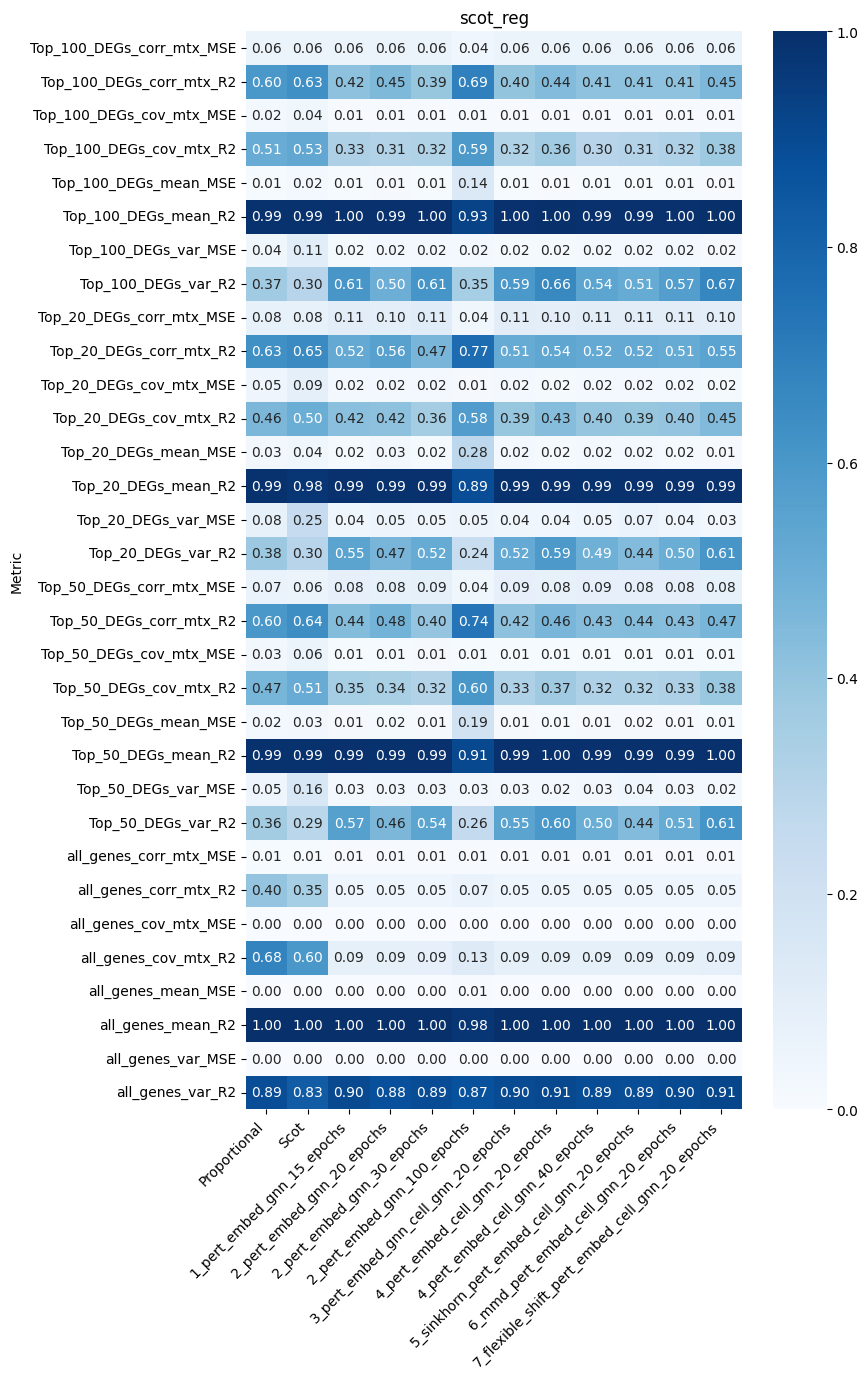

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample Data (Replace with your actual data)
data = {
    "Metric": [
        "Top_100_DEGs_corr_mtx_MSE", "Top_100_DEGs_corr_mtx_R2", "Top_100_DEGs_cov_mtx_MSE", "Top_100_DEGs_cov_mtx_R2",
        "Top_100_DEGs_mean_MSE", "Top_100_DEGs_mean_R2", "Top_100_DEGs_var_MSE", "Top_100_DEGs_var_R2",
        "Top_20_DEGs_corr_mtx_MSE", "Top_20_DEGs_corr_mtx_R2", "Top_20_DEGs_cov_mtx_MSE", "Top_20_DEGs_cov_mtx_R2",
        "Top_20_DEGs_mean_MSE", "Top_20_DEGs_mean_R2", "Top_20_DEGs_var_MSE", "Top_20_DEGs_var_R2",
        "Top_50_DEGs_corr_mtx_MSE", "Top_50_DEGs_corr_mtx_R2", "Top_50_DEGs_cov_mtx_MSE", "Top_50_DEGs_cov_mtx_R2",
        "Top_50_DEGs_mean_MSE", "Top_50_DEGs_mean_R2", "Top_50_DEGs_var_MSE", "Top_50_DEGs_var_R2",
        "all_genes_corr_mtx_MSE", "all_genes_corr_mtx_R2", "all_genes_cov_mtx_MSE", "all_genes_cov_mtx_R2",
        "all_genes_mean_MSE", "all_genes_mean_R2", "all_genes_var_MSE", "all_genes_var_R2"
    ],
    "Proportional": [0.06, 0.60, 0.02, 0.51, 0.01, 0.99, 0.04, 0.37, 0.08, 0.63, 0.05, 0.46, 0.03, 0.99, 0.08, 0.38,
                     0.07, 0.60, 0.03, 0.47, 0.02, 0.99, 0.05, 0.36, 0.01, 0.40, 0.00, 0.68, 0.00, 1.00, 0.00, 0.89],
    "Scot": [0.06, 0.63, 0.04, 0.53, 0.02, 0.99, 0.11, 0.30, 0.08, 0.65, 0.09, 0.50, 0.04, 0.98, 0.25, 0.30,
             0.06, 0.64, 0.06, 0.51, 0.03, 0.99, 0.16, 0.29, 0.01, 0.35, 0.00, 0.60, 0.00, 1.00, 0.00, 0.83]
}

# Create DataFrame
df = pd.DataFrame(data)
df.set_index("Metric", inplace=True)

files = ['1_pert_embed_gnn_15_epochs_r2.pkl','2_pert_embed_gnn_20_epochs_r2.pkl','2_pert_embed_gnn_30_epochs_r2.pkl','2_pert_embed_gnn_100_epochs_r2.pkl',
         '3_pert_embed_gnn_cell_gnn_20_epochs_r2.pkl','4_pert_embed_cell_gnn_20_epochs_r2.pkl','4_pert_embed_cell_gnn_40_epochs_r2.pkl','5_sinkhorn_pert_embed_cell_gnn_20_epochs_r2.pkl',
         '6_mmd_pert_embed_cell_gnn_20_epochs_r2.pkl','7_flexible_shift_pert_embed_cell_gnn_20_epochs_r2.pkl']
for filename in files:
    with open(filename, 'rb') as f:
        result_dict = pickle.load(f)
    new_data = result_dict
    new_df = pd.DataFrame.from_dict(new_data, orient='index', columns=[filename[:-7]])
    df = df.merge(new_df, left_index=True, right_index=True, how="left")
# Create heatmap
plt.figure(figsize=(8, 14))
ax = sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.title("scot_reg")

# Show plot
plt.show()


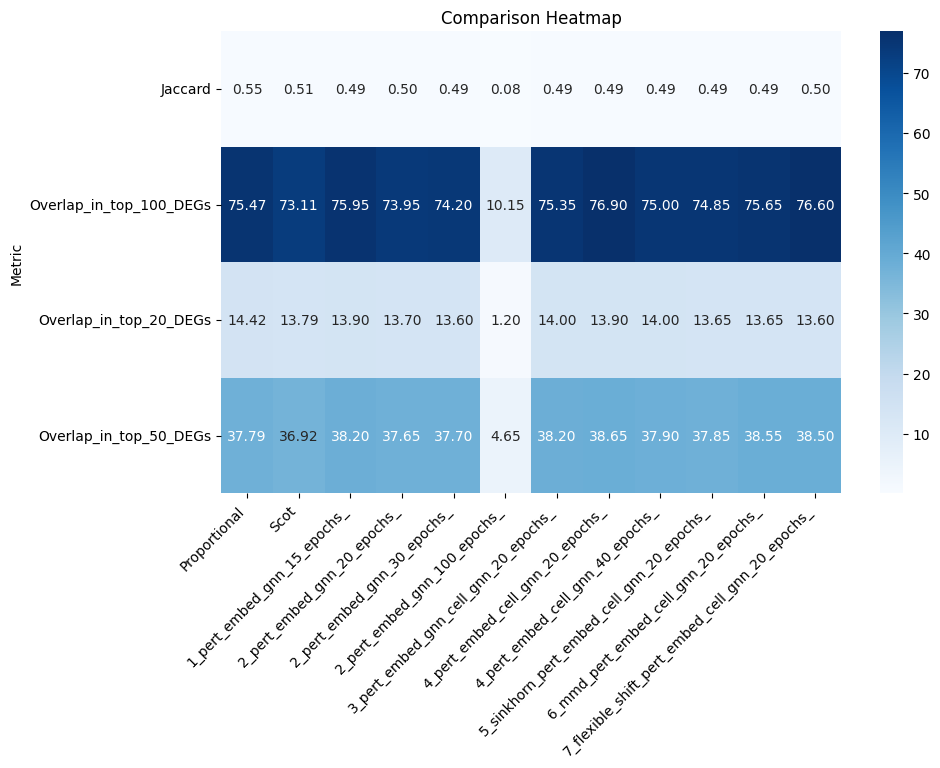

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample Data (Replace with actual values)
data = {
    "Metric": [
        "Jaccard", 
        "Overlap_in_top_100_DEGs", 
        "Overlap_in_top_20_DEGs", 
        "Overlap_in_top_50_DEGs"
    ],
    "Proportional": [0.55, 75.47, 14.42, 37.79],
    "Scot": [0.51, 73.11, 13.79, 36.92]
}

# Create DataFrame
df = pd.DataFrame(data)
df.set_index("Metric", inplace=True)

files = ['1_pert_embed_gnn_15_epochs_deg.pkl','2_pert_embed_gnn_20_epochs_deg.pkl','2_pert_embed_gnn_30_epochs_deg.pkl','2_pert_embed_gnn_100_epochs_deg.pkl',
         '3_pert_embed_gnn_cell_gnn_20_epochs_deg.pkl','4_pert_embed_cell_gnn_20_epochs_deg.pkl','4_pert_embed_cell_gnn_40_epochs_deg.pkl','5_sinkhorn_pert_embed_cell_gnn_20_epochs_deg.pkl',
         '6_mmd_pert_embed_cell_gnn_20_epochs_deg.pkl','7_flexible_shift_pert_embed_cell_gnn_20_epochs_deg.pkl']

for filename in files:
    with open(filename, 'rb') as f:
        result_dict = pickle.load(f)
    new_data = result_dict
    new_df = pd.DataFrame.from_dict(new_data, orient='index', columns=[filename[:-7]])
    df = df.merge(new_df, left_index=True, right_index=True, how="left")
# Create heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.title("Comparison Heatmap")

# Show plot
plt.show()
